In [1]:
import alignment, speech, applause_list, text_features,re

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
#import spacy
#nlp = spacy.load('en')

In [3]:
import json
import os
import pickle
import json
from IPython.display import Audio
import keras
import numpy as np
import librosa
from sklearn.utils import shuffle
import pandas as pd
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
s = speech.Speech('bernie_sanders/bernie_sanders_20')
a_list = applause_list.ApplauseList(s.applause_times_file)
instances = a_list.get_instances()
align = alignment.Alignment(s.alignment_file)

In [5]:
trump = speech.Speech('donald_trump/donald_trump_4')
trump_list = applause_list.ApplauseList(trump.applause_times_file)
trump_instances = trump_list.get_instances()
trump_align = alignment.Alignment(trump.alignment_file)

In [27]:
s.load_librosa()
trump.load_librosa()

In [6]:
preds_by_second = np.array(s.get_preds_by_second())
trump_preds_by_second = np.array(trump.get_preds_by_second())
#plt.plot(pd.rolling_mean(preds_by_second,3))

In [7]:
index_lists = [align.get_indices_within_time_range(i,i+1) for i in range(len(preds_by_second))]
char_lists = [align.get_chars_from_indices(i) if len(i) > 0 else [] for i in index_lists]
nonzero_indices = [i for i,c in enumerate(char_lists) if len(c) > 0]
combo = zip(char_lists,preds_by_second)

In [8]:
trump_index_lists = [trump_align.get_indices_within_time_range(i,i+1) for i in range(len(trump_preds_by_second))]
trump_char_lists = [trump_align.get_chars_from_indices(i) if len(i) > 0 else [] for i in trump_index_lists]
trump_nonzero_indices = [i for i,c in enumerate(trump_char_lists) if len(c) > 0]
trump_combo = zip(trump_char_lists,trump_preds_by_second)

In [28]:
#re.match("\[.*\]","[CHEERING]")

In [29]:
Audio(trump.y[0:30*trump.sr],rate=trump.sr)

In [9]:
raw_text = trump_align.get_preceding_chars(200)
tf = text_features.TextFeatures(raw_text)
tf.sentences

[u'CHANGE  BEGINS  IMMEDIATELY  WITH  THE  REPEALING  AND  REPLACING  ALL  OF  KNOWN  AS  OBAMACARE . ',
 u'[ CHEERING ] ...',
 u'THIS  IS  A  GREAT  ROOM . ',
 u'WE  HAVE  GREAT  ACTORS  IN  THIS  ROOM ,  BY  THE  WAY .  -- ',
 u'WE  HAVE  GREAT  PICTURES  IN  THIS  ROOM ,  BY  THE  WAY']

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [ ]:
test_stationarity(preds_by_second[25:])

In [38]:
X = preds_by_second[25:]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.026


In [50]:
X = preds_by_second[25:]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(3,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.027


In [ ]:
X = preds_by_second[25:]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(3,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/usr/lib/python2.7/dist-packages/statsmodels/tsa/tsatools.py:539: RuntimeWarning: divide by zero encountered in divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/lib/python2.7/dist-packages/statsmodels/tsa/tsatools.py:513: RuntimeWarning: invalid value encountered in divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/lib/python2.7/dist-packages/statsmodels/tsa/tsatools.py:514: RuntimeWarning: invalid value encountered in divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


In [13]:
def get_lag_factors(series,p=5):
    X = []
    y = []
    for index in range(p,len(series)):
        lag_features = list(series[index-p:index])
        X.append(series[index-p:index])
        y.append(series[index])
    return X,y

In [78]:
X,y = get_lag_factors(preds_by_second[25:],p=8)

In [79]:
len(y)*0.8

2859.2000000000003

In [80]:
from sklearn import linear_model
from sklearn import svm

In [81]:
#linreg=linear_model.Ridge(alpha=35)
clf = svm.SVR(C=0.1)
X_train, y_train = X[0:2860], y[0:2860]
X_test, y_test = X[2860:],y[2860:]

In [82]:
clf.fit(X_train,y_train)
linreg_preds = clf.predict(X_test)
error = mean_squared_error(linreg_preds, y_test)
print error

0.0339302539966


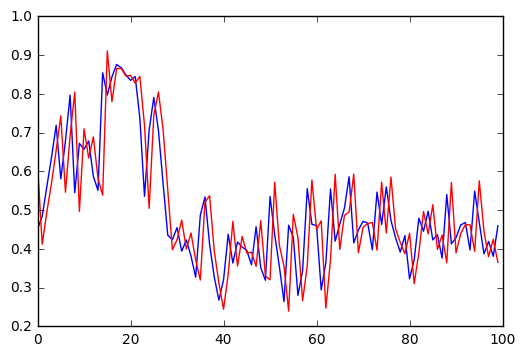

In [39]:
# plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()

In [29]:
trump_combo[140:170]

[(u'INTEREST DONORS', 0.036200922),
 ([], 0.016711384),
 (u'AND THE SPECIAL', 0.021558831),
 (u'INTERESTS THEMSELVES', 0.020028658),
 ([], 0.1562575),
 (u'AND HILLARY IS', 0.13132043),
 (u'THE FACE', 0.051708311),
 (u'OF FAILURE', 0.10130229),
 (u'SHE IS THE', 0.031754918),
 (u'FACE OF FAILURE', 0.20428096),
 ([], 0.30124262),
 (u'SHE IS THE FACE', 0.23696156),
 (u'OF FAILED', 0.28528297),
 (u'FOREIGN POLICY', 0.34286305),
 ([], 0.53291905),
 ([], 0.63132668),
 ([], 0.73208821),
 (u'REAL CHANGE', 0.542647),
 (u'BEGINS', 0.39520219),
 ([], 0.84599864),
 ([], 0.90360385),
 ([], 0.87044138),
 ([], 0.81631655),
 (u'SHE IS INDEED', 0.13571548),
 (u'THE FACE OF', 0.050474647),
 (u'FAILURE', 0.11571791),
 (u'LOOK AT WHAT', 0.20718512),
 (u"SHE'S DONE WITH", 0.15628083),
 (u'E-MAILS. LOOK', 0.044596139),
 (u'AT THE MESS', 0.10835201)]

In [32]:
start_second = 970; end_second = 1000
Audio(s.y[s.sr*start_second:s.sr*end_second],rate=s.sr)

In [54]:
trump_combo[600:630]

[(u'CORRUPT PERSON', 0.086281389),
 (u'EVER TO SEEK', 0.070206195),
 (u'THE OFFICE', 0.077407382),
 (u'OF THE PRESIDENCY', 0.03689399),
 (u'OF THE UNITED STATES', 0.031000882),
 ([], 0.30270788),
 (u'SHE', 0.71519488),
 (u'HAS THREATENED NATIONAL', 0.30191469),
 (u'SECURITY', 0.08892709),
 (u'SHE SOLD', 0.054279279),
 (u'HER OFFICE TO THE', 0.072960876),
 (u'HIGHEST BIDDER', 0.10748889),
 (u'AND THEN TO', 0.14539291),
 (u'COVER HER TRACKS', 0.25267753),
 (u'SHE', 0.055729028),
 (u'DELETED', 0.021276265),
 (u'33', 0.04291074),
 (u'000 E', 0.11995894),
 (u'MAILS AFTER', 0.15227903),
 (u'RECEIVING', 0.054068755),
 ([], 0.017414318),
 (u'A CONGRESSIONAL', 0.022045095),
 (u'SUBPOENA', 0.048175175),
 ([], 0.59297782),
 ([], 0.76006413),
 ([], 0.81239861),
 ([], 0.81187999),
 ([], 0.85498351),
 ([], 0.92208391),
 ([], 0.90605545)]

In [53]:
trump_start_second = 600; trump_end_second = 630
Audio(trump.y[s.sr*trump_start_second:trump.sr*trump_end_second],rate=trump.sr)

In [9]:
s.load_librosa()

In [109]:
#indices = align.get_indices_within_time_range(812,819)
#word_list = align.get_word_list_from_indices(indices)
#char_list = align.get_chars_from_indices(indices)

In [79]:
preceding_time = align.get_start_end_times_from_indices(indices)

In [80]:
Audio(s.y[int(preceding_time[0]*s.sr):int(preceding_time[1]*s.sr)],rate=s.sr)

AttributeError: Speech instance has no attribute 'y'

In [81]:
Audio(s.y[int(instances[i][0]*s.sr):int(instances[i][1]*s.sr)],rate=s.sr)

AttributeError: Speech instance has no attribute 'y'

In [65]:
char_list

u'ABOUT  ALL OF THE THINGS GOVERNOR  WALKER DOES, AND I WILL DO IT EXACTLY THE OPPOSITE. [APPLAUSE'

In [51]:
preceding_time

(843.63, 850.6500000000001)

In [32]:
instances[i]

(851.60925, 857.64541)

In [23]:
instances[i]

(818.51792, 822.69735)